# XGBoost hyperparameter search using hyperopt: OPERA study example

This notebook demonstrates how to perform hyperparameter optimization using Hyperopt on data from the OPERA study. Hyperopt implements a directed search strategy based on Tree-Structured Parzen Estimators (TPE), which allows it to explore the hyperparameter space more efficiently than traditional grid search.

Here, we use Hyperopt to tune an XGBoost model, identifying parameter configurations that improve predictive performance while reducing computational cost. This serves as a practical example of modern, Bayesian-inspired hyperparameter optimization in biomedical machine-learning workflows.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
import xgboost as xgb

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from hyperopt import hp, fmin, tpe, rand, pyll, STATUS_OK, STATUS_FAIL, Trials, space_eval



In [3]:
# Load input dataset

df = pd.read_csv("../data/OPERA.csv", index_col=[0,1])
df.index = df.index.droplevel(level=0)

df = df.transpose()
df.head()

targets = ['BPISeverityChange','BPIInterferenceChange', 
           'ChangeGrandTotalMedicines','ChangeInTotalComplaintsNotIncludingOther']
X = df.drop(columns=targets)
Y = df[targets]

y = df['BPISeverityChange']
X = df.drop(columns=targets)

In [4]:
# Deal with features that are highly correlated (forms clusters on the correlation heatmap)
# Pick 1–2 representative features per correlated block

def remove_correlated_features(X, y, corr_threshold=0.8):
    """
    Iteratively remove features that are too correlated with each other.
    Between each correlated pair, we drop the one less correlated with y.
    
    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix (no target column).
    y : pd.Series or 1D array
        Target variable.
    corr_threshold : float
        Absolute correlation threshold above which we consider features "too correlated".
    
    Returns
    -------
    kept_columns : list
        List of feature names kept.
    dropped_columns : list
        List of dropped feature names.
    """
    X_corr = X.corr().abs().copy()
    
    # Correlation of each feature with the target (for deciding which to keep)
    corr_with_y = X.apply(lambda col: col.corr(y)).abs()
    
    # We’ll work on a copy of the column names
    cols = list(X_corr.columns)
    dropped = []

    # Set diagonal to 0 so we don’t pick self-correlation
    np.fill_diagonal(X_corr.values, 0.0)
    
    while True:
        # Find the pair with maximum correlation
        max_corr = X_corr.values.max()
        if max_corr < corr_threshold:
            break  # we're done
        
        # indices of the max correlation
        i, j = np.where(X_corr.values == max_corr)
        i, j = i[0], j[0]
        
        col_i = cols[i]
        col_j = cols[j]
        
        # Decide which one to drop: keep the one more correlated with y
        if corr_with_y[col_i] < corr_with_y[col_j]:
            col_to_drop = col_i
        else:
            col_to_drop = col_j
        
        dropped.append(col_to_drop)
        
        # Remove from correlation matrix & lists
        drop_idx = cols.index(col_to_drop)
        cols.pop(drop_idx)
        X_corr = X_corr.drop(index=col_to_drop, columns=col_to_drop)
        
        # also drop from corr_with_y
        corr_with_y = corr_with_y.drop(col_to_drop)
        
        # reset diagonal to 0 after shape changed
        np.fill_diagonal(X_corr.values, 0.0)
    
    kept = cols
    return kept, dropped

kept_cols, dropped_cols = remove_correlated_features(X, y, corr_threshold=0.8)

print("Kept:", kept_cols)
print("Dropped:", dropped_cols)

X_reduced = X[kept_cols]

Kept: ['Age', 'Gender', 'Overall_Pain_interference', 'Int_Gen_Activity', 'Int_Mood', 'Int_Walking_ability', 'Int_Work', 'Int_Relationship', 'Int_Sleep', 'Arthritis_bin', 'Arthritis_categ', 'Int_Life_enjoyment', 'Meds_3days', 'Categ_of_meds', 'OTC_bin', 'OTC_categ', 'AntiInflam_categ', 'Narcotic_categ', 'NeuroRadic_bin', 'NeuroRadic_cat', 'MyoMuscul_cat', 'MyoMuscul_bin', 'Tendinitis_cat', 'Other_cat', 'Pain_other', 'Worst_24h', 'Grand_Tot_Compl', 'Not_on_Anticonvulsant', 'Pain_categ', 'Opioid_comb', 'Severity_Score', 'TFFC1', 'TFFC2', 'TFFC3', 'TFFC4']
Dropped: ['AntiInflam_weight', 'Narcotic_weight', 'Tot_Compl_categ', 'Opioid_others', 'Grand_Tot_Med_weight', 'AntiInflam_bin', 'Current_pain', 'Narcotic_bin', 'Other_bin', 'Avg_Interference', 'Tendinitis_bin', 'Average_pain', 'Least_24h', 'Opioids_No_Anticonvulsants', 'Grand_Tot_Med']


In [ ]:
Xt, Xv, yt, yv = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)
print(f"train set length: {len(yt)}")
print(f"valid set length: {len(yv)}")

train set length: 504
valid set length: 127


## "Basic" usage of hyperopt

In [ ]:
def hyperopt_xgb_train(params):
    xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count() - 2,
        **params
    )
    xgb_model.fit(Xt, yt)

    proba = xgb_model.predict_proba(Xv)[:, 1]  # prob of positive class
    auc = roc_auc_score(yv, proba)
    loss = -auc

    return {
        'loss': loss,
        'status': STATUS_OK
    }

params = dict(
    n_estimators=100,
    eta=0.3,          # or use learning_rate=0.3
    subsample=0.8,
    max_depth=5
)


hyperopt_xgb_train( params )

{'loss': np.float64(-0.7384879725085911), 'status': 'ok'}

## Parameter search-space

Here are notes on Hyperopt’s low-level sampling machinery, shown explicitly so we can see how Hyperopt defines and samples from prior distributions over hyperparameters. The way it works is that for each hyper-parameter we define a **prior distribution** (it is bayesian after all) using one of hyperopt function.

For a more detailed documentation we refer you to the [hyperopt documentation](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/)

In [ ]:
# Defining prior distributions

# This defines a search space node saying:
# "The hyperparameter named simple is drawn from a uniform distribution between 0 and 1."
simple_uniform = hp.uniform('simple', 0, 1)
print(simple_uniform)
# This forces Hyperopt to sample a random actual value from the distribution you defined.
print(pyll.stochastic.sample(simple_uniform))
# This defines a log-uniform prior distribution, which is commonly used for learning rates:
# This means η will vary from very small (0.0001) to very large (100) but in a logarithmically fair way.
eta = hp.loguniform('eta' , np.log(10**-4) , np.log(10**2) )
# this draws a single sample from the distribution you defined
print(pyll.stochastic.sample(eta))


0 float
1   hyperopt_param
2     Literal{simple}
3     uniform
4       Literal{0}
5       Literal{1}
0.5957609917701654
0.000249747182947705


In [ ]:
# Hyperopt optimization run
# 
# The space4xgb definition: defining a Hyperopt search space
# which prior distribution could we give `n_estimators`? to `max_depth` ? 
space4xgb = {
    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 1 , 1000,1)),
    'eta': hp.loguniform('eta' , np.log(10**-4) , np.log(10**2) ),
    'max_depth': pyll.scope.int(hp.quniform('max_depth', 1, 16, 1)),
    'subsample': hp.uniform('subsample', 0.3, 1)
}
trials = Trials()

best = fmin(hyperopt_xgb_train, 
            space4xgb, 
            algo=tpe.suggest, 
            max_evals=20, 
            trials=trials)

100%|██████████| 20/20 [00:04<00:00,  4.83trial/s, best loss: -0.7890034364261168]


In [ ]:
# This is the best hyperparameter set Hyperopt found among the 20 trials, i.e. the one with lowest loss (highest AUC, since loss = –AUC).

print(best)

{'eta': np.float64(0.00024608768491285877), 'max_depth': np.float64(5.0), 'n_estimators': np.float64(800.0), 'subsample': np.float64(0.3657708214392494)}
eta [np.float64(1.2367538360617791), np.float64(0.0008481288634509128), np.float64(0.003570273382088377), np.float64(0.16459654159288817), np.float64(0.10190214243416944)]
max_depth [np.float64(12.0), np.float64(13.0), np.float64(10.0), np.float64(14.0), np.float64(7.0)]
n_estimators [np.float64(114.0), np.float64(643.0), np.float64(767.0), np.float64(159.0), np.float64(253.0)]
subsample [np.float64(0.41290935822047176), np.float64(0.7663942051377449), np.float64(0.9299676159427257), np.float64(0.7731859601325033), np.float64(0.5323521147843558)]


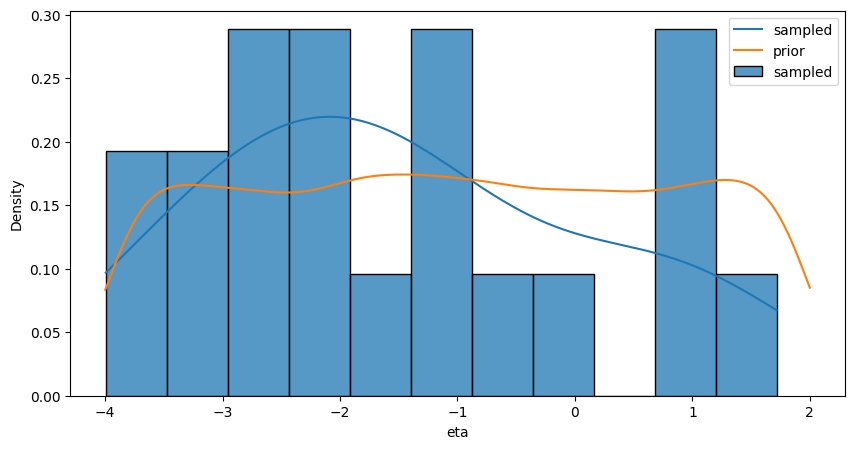

In [17]:
# Visualizing how the posterior search behavior (sampled η) compares to the original prior for η.

# The orange curve (prior) shows where Hyperopt could sample η before seeing any results.
# The blue histogram/curve (sampled) shows where Hyperopt actually sampled η during optimization.
# If those two distributions differ, it means the TPE algorithm has learned that certain η ranges are more promising and concentrates evaluations there.

fig,ax = plt.subplots(figsize=(10,5))

sns.kdeplot( np.log10( trials.vals['eta'] ) , ax=ax , cut = 0 , label='sampled')
sns.histplot( np.log10( trials.vals['eta'] ) , binwidth=0.5 , ax=ax , label='sampled' , stat = 'density')

sns.kdeplot( [ np.log10( pyll.stochastic.sample(eta) ) for _ in range(10000) ] , ax=ax , cut = 0 , label='prior')
ax.set_xlabel('eta')
ax.legend()


Text(0, 0.5, 'loss')

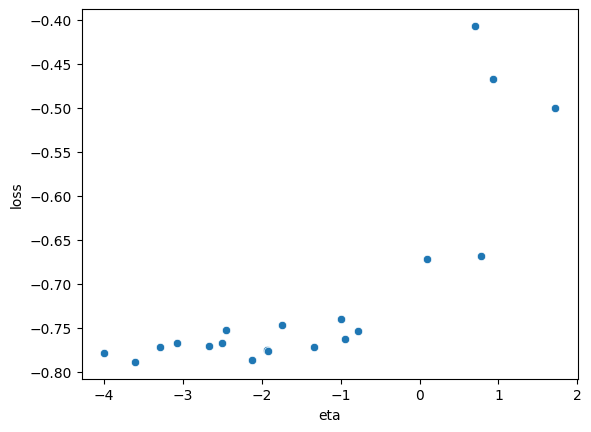

In [ ]:
# How the hyperparameter η (learning rate) affects the objective function (loss) during the Hyperopt search?
# XGBoost prefers small learning rates on this OPERA validation split.
ax = sns.scatterplot( x = np.log10( trials.vals['eta'] ) ,
                 y =  trials.losses() )
ax.set_xlabel('eta')
ax.set_ylabel('loss')

Text(0, 0.5, 'loss')

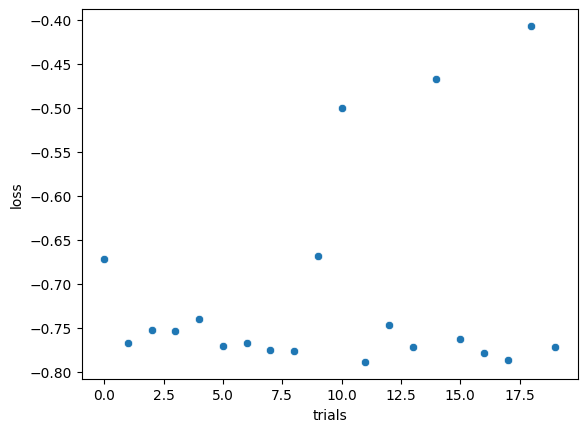

In [ ]:
# How the loss changes over the course of the Hyperopt optimization, i.e. trial number vs. model performance.
# 
# This is essentially the optimization trajectory:
# At the start → random, varied performance
# Middle → Hyperopt zooms in on the good hyperparameter regions
# Later → Fine-grained exploration around promising areas

ax = sns.scatterplot( x =  range(len(trials.losses())) ,  y =  trials.losses() )
ax.set_xlabel('trials')
ax.set_ylabel('loss')

# Changing the cross-validation scheme

Let's switch from a single train/validation split to the hyperopt optimization of XGBoost hyperparameters, where each trial is evaluated by 5-fold stratified CV using ROC-AUC as the score.

In [ ]:
skf = StratifiedKFold(n_splits=5 , shuffle=True , random_state = 2024 )
for t,v in skf.split( X, y ): #split on the full dataset

    print(len(t), t[:5])
    print(len(v), v[:5])

504 [2 3 4 6 7]
127 [ 0  1  5  8 16]
505 [0 1 2 3 4]
126 [ 6  7 10 18 29]
505 [0 1 4 5 6]
126 [ 2  3 12 13 22]
505 [0 1 2 3 4]
126 [ 9 11 14 15 17]
505 [0 1 2 3 5]
126 [ 4 32 37 48 49]


In [23]:
cross_val_score( xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2) , 
                X, y, scoring = 'roc_auc_ovr' , cv = skf )

array([0.69882353, 0.71128713, 0.68475248, 0.65267327, 0.75168317])

In [26]:
## tentative solution
def hyperopt_xgb_train_CV5( params ):
    
    skf = StratifiedKFold(n_splits=5 , shuffle=True , random_state = 2024 )
    
    losses = -1 * cross_val_score( xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2 , **params) , 
                X, y, scoring = 'roc_auc_ovr' , cv = skf )
        
    return_dict = {'loss': np.mean(losses),
                   'loss_variance' : np.var(losses),
                   'status': STATUS_OK
                   }
    return return_dict
params = dict( n_estimators=100,
               eta = 0.3,
               subsample = 0.8,
               max_depth = 5)
#hyperopt_xgb_train_CV5( params ) # just ot test the function

trials = Trials()
best = fmin(hyperopt_xgb_train_CV5, 
            space4xgb, 
            algo=tpe.suggest, 
            max_evals=10, 
            trials=trials)

print(best)
print(len( trials ))

100%|██████████| 10/10 [00:09<00:00,  1.11trial/s, best loss: -0.7133892448068337]
{'eta': np.float64(0.016013446141395882), 'max_depth': np.float64(7.0), 'n_estimators': np.float64(612.0), 'subsample': np.float64(0.8100858591558433)}
10


# Nested search space

This defines a mixed model search space:

- With probability 0.6, Hyperopt chooses the XGBoost branch and samples: `n_estimators, eta, max_depth, subsample`. 
- With probability 0.4, it chooses the logistic regression branch and samples: `C and penalty`

So each trial either:

- evaluates an XGBoost model with its own hyperparameters, or

- evaluates a logistic regression with its own hyperparameters.

This lets Hyperopt jointly decide:

- Which model type is better (XGBoost vs. logistic regression), and

- What hyperparameters are best within each model type.


It is possible nest elements in `hp.choice()` or `hp.pchoice()` to specify more complex search spaces:

In [27]:
space4nested = hp.pchoice('classifier_type',
                          [(0.6, {'classifier_type': 'xgboost',
                                    'n_estimators': pyll.scope.int(hp.quniform('n_estimators', 1 , 1000,1)),
                                    'eta': hp.loguniform('eta' , np.log(10**-4) , np.log(10**2) ),
                                    'max_depth': pyll.scope.int(hp.quniform('max_depth', 1, 16, 1)),
                                    'subsample': hp.uniform('subsample', 0.3, 1)
                                  }
                            ),
                           (0.4, {'classifier_type': 'logistic regression',
                                  'C': hp.loguniform("C", low=np.log(1e-5), high=np.log(1e2)),
                                  'penalty': hp.choice('penalty', ['l1','l2'])
                                  }
                            )]
                          )

In [31]:
def hyperopt_complex_train_CV5( params ):
    
    classif_type = params.pop('classifier_type')
    
    model = None
    if classif_type == 'xgboost':
        model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2 , **params) 
    
    else:
        model =Pipeline([('scalar',StandardScaler()), 
                      ('model',LogisticRegression(solver ='liblinear', class_weight='balanced', **params))])
    
    losses = -1 * cross_val_score( model  , 
                    X, y, scoring = 'accuracy' , cv = skf )
        
    return_dict = {'loss': np.mean(losses),
                   'loss_variance' : np.var(losses),
                   'status': STATUS_OK
                   }
    return return_dict


trials = Trials()
best = fmin(hyperopt_complex_train_CV5, 
            space4nested, 
            algo=tpe.suggest, 
            max_evals=15, 
            trials=trials)

100%|██████████| 15/15 [00:07<00:00,  1.96trial/s, best loss: -0.8018997625296838]


In [34]:
best

{'C': np.float64(0.0008247504707694173),
 'classifier_type': np.int64(1),
 'penalty': np.int64(0)}

In [32]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.7607049118860142,
   'loss_variance': np.float64(0.0002577111931749685),
   'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'C': [],
    'classifier_type': [np.int64(0)],
    'eta': [np.int64(0)],
    'max_depth': [np.int64(0)],
    'n_estimators': [np.int64(0)],
    'penalty': [],
    'subsample': [np.int64(0)]},
   'vals': {'C': [],
    'classifier_type': [np.int64(0)],
    'eta': [np.float64(0.7749068264018086)],
    'max_depth': [np.float64(13.0)],
    'n_estimators': [np.float64(277.0)],
    'penalty': [],
    'subsample': [np.float64(0.5234711195181655)]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2025, 11, 20, 20, 16, 48, 666000),
  'refresh_time': datetime.datetime(2025, 11, 20, 20, 16, 49, 212000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': -0.8018997625296838,
   'loss_varia

Logistic regression is competitive with XGBoost on this dataset. Both achieve similar best loss values (~ –0.80 → AUC ~ 0.80–0.81).

Text(0, 0.5, 'loss')

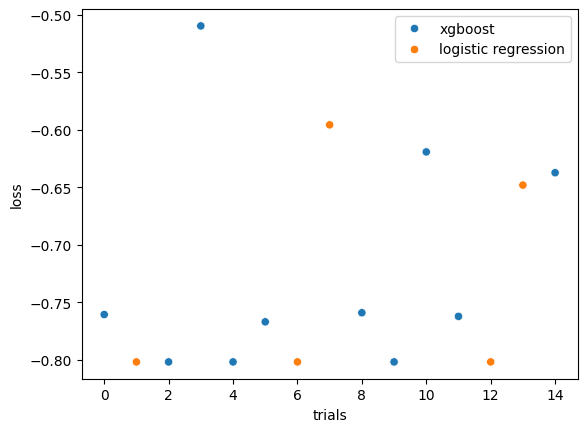

In [33]:
ax = sns.scatterplot( x =  range(len(trials.losses())) ,  y =  trials.losses() , 
                     hue = np.array(['xgboost','logistic regression'])[trials.vals['classifier_type']] )
ax.set_xlabel('trials')
ax.set_ylabel('loss')